In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler


seed = 331

In [2]:
def resultPlot(x_name, x, fnr, fpr, roc_auc, sensitivities, specificities, scale=1, marker=None):
    fig = plt.figure(figsize = (5, 5))
    
    colors = ['r', 'g', 'b', 'c', 'm']

    plt.plot(x, fnr, color=colors[0], marker=marker, label ='FNR')
    plt.plot(x, fpr, color=colors[1], marker=marker, label ='FPR')
    plt.plot(x, roc_auc, color=colors[2], marker=marker, label ='ROC AUC')
    plt.plot(x, sensitivities, color=colors[3], marker=marker, label ='Sensitivity')
    plt.plot(x, specificities, color=colors[4], marker=marker, label ='Specificity')

    # # Adding Xticks
    plt.xlabel(x_name, fontweight ='bold', fontsize = 15)
    plt.ylabel('Value', fontweight ='bold', fontsize = 15)
    if scale > 1:
        plt.xticks([x[i] for i in range(0,len(x),scale)])
    else:
        plt.xticks(x)

    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.show()

In [3]:
def fnr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fn / (fn + tp)

def fpr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fp / (fp + tn)



def model_metrics(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tp + tn)
    
    return fnr, fpr, roc_auc, sensitivity, specificity

# Data preparation

In [4]:
dataframe = pd.read_csv("./data/creditcard.csv")

columns = dataframe.columns.drop('Class')

dataframe.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
scaled_dataframe = dataframe.copy().drop(['Class'],axis=1)

transformer = StandardScaler()

transformer.fit(scaled_dataframe)

scaled_dataframe = transformer.transform(scaled_dataframe)
scaled_dataframe = pd.DataFrame(scaled_dataframe, columns=columns)

In [6]:
X = scaled_dataframe
y = dataframe.Class

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed, test_size=0.33)

print("train rows: {}, test rows: {}".format(X_train.shape[0], X_test.shape[0]))

train rows: 190820, test rows: 93987


# Testing QDA classifier

In [78]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)

qda.score(X_test, y_test)

0.9742198389138923

In [79]:
y_pred = qda.predict(X_test)

In [80]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
cm

array([[  139,    18],
       [ 2405, 91425]], dtype=int64)

In [81]:
fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr * 100, fpr * 100))
print("ROC AUC = {:.4f}".format(roc_auc * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity * 100, specificity * 100))

FNR = 11.4650%, FPR = 2.5631%
ROC AUC = 92.9859
sensitivity = 88.5350%, specificity = 99.8482%


## Testing other QDA settings

In [82]:
reg_params = np.arange(0.01, 1.01, 0.01)
store_covariance_opt: [True, False]
tols = [0.0001, 0.001, 0.01, 0.1]

fnrs_1 = []
fprs_1 = []
roc_aucs_1 = []
sensitivities_1 = []
specificities_1 = []

for reg_param in reg_params:
    qda = QuadraticDiscriminantAnalysis(reg_param=reg_param, store_covariance=False)
    qda.fit(X_train, y_train)
    y_pred = qda.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_1.append(fnr)
    fprs_1.append(fpr)
    roc_aucs_1.append(roc_auc)
    sensitivities_1.append(sensitivity)
    specificities_1.append(specificity)

In [83]:
min_fnr = 100
best_reg_param = 0
for i in range(len(fnrs_1)):
    if (fprs_1[i] * 100 < 0.5 and fnrs_1[i] < min_fnr):
        min_fnr = fnrs_1[i]
        best_reg_param = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs_1[best_reg_param] * 100, fprs_1[best_reg_param] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs_1[best_reg_param] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities_1[best_reg_param] * 100, specificities_1[best_reg_param] * 100))

print("Best reg_param = {:.2f}".format(reg_params[best_reg_param]))

best_reg_p = reg_params[best_reg_param]

qda = QuadraticDiscriminantAnalysis(reg_param=best_reg_p, store_covariance=False)
qda.fit(X_train, y_train)
y_pred_best = qda.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=[1,0])
cm

FNR = 14.0127%, FPR = 0.4881%
ROC AUC = 92.7496
sensitivity = 85.9873%, specificity = 99.8556%
Best reg_param = 0.97


array([[  135,    22],
       [  458, 93372]], dtype=int64)

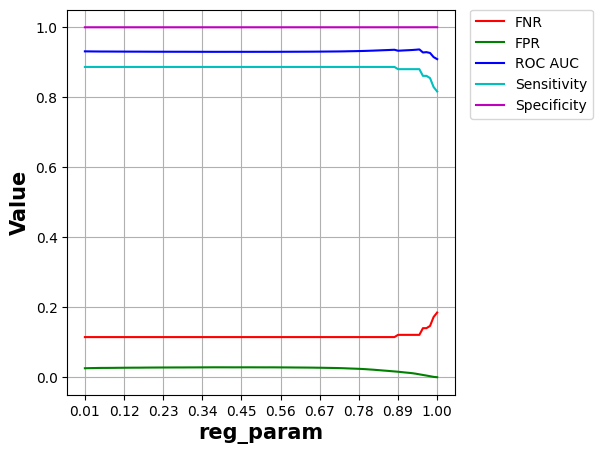

In [102]:
resultPlot('reg_param', reg_params, fnrs_1, fprs_1, roc_aucs_1, sensitivities_1, specificities_1, scale=11)

#  Balancing Classes

### Random under-sampling

In [7]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
undersampled_dataframe = RandomUnderSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_und, y_train_und = undersampled_dataframe

print(y_train_und.value_counts())

0    335
1    335
Name: Class, dtype: int64


In [9]:
qda_und = QuadraticDiscriminantAnalysis(reg_param=0.97, store_covariance=False)

qda_und.fit(X_train_und,y_train_und)

y_pred_und = qda_und.predict(X_test)

cm_und = confusion_matrix(y_test, y_pred_und, labels=[1,0])
cm_und

array([[  135,    22],
       [  625, 93205]], dtype=int64)

In [10]:
fnr_und, fpr_und, roc_auc_und, sensitivity_und, specificity_und = model_metrics(y_test, y_pred_und)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_und * 100, fpr_und * 100))
print("ROC AUC = {:.4f}".format(roc_auc_und))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_und * 100, specificity_und * 100))

FNR = 14.0127%, FPR = 0.6661%
ROC AUC = 0.9266
sensitivity = 85.9873%, specificity = 99.8554%


### Random over-sampling

In [11]:
from imblearn.over_sampling  import RandomOverSampler

In [12]:
oversampled_dataframe = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_ov, y_train_ov = oversampled_dataframe

print(y_train_ov.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [13]:
qda_ov = QuadraticDiscriminantAnalysis(reg_param=0.97, store_covariance=False)
qda_ov.fit(X_train_ov,y_train_ov)

y_pred_ov = qda_ov.predict(X_test)

cm_ov = confusion_matrix(y_test, y_pred_ov, labels=[1,0])
cm_ov

array([[  135,    22],
       [  572, 93258]], dtype=int64)

In [14]:
fnr_ov, fpr_ov, roc_auc_ov, sensitivity_ov, specificity_ov = model_metrics(y_test, y_pred_ov)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_ov * 100, fpr_ov * 100))
print("ROC AUC = {:.4f}".format(roc_auc_ov))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_ov * 100, specificity_ov * 100))

FNR = 14.0127%, FPR = 0.6096%
ROC AUC = 0.9269
sensitivity = 85.9873%, specificity = 99.8554%


### Smote over-sampling

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
SMOTE_dataframe = SMOTE(random_state=seed).fit_resample(X_train, y_train)

X_train_SMOTE, y_train_SMOTE = SMOTE_dataframe

print(y_train_SMOTE.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [17]:
qda_SMOTE = QuadraticDiscriminantAnalysis(reg_param=0.97, store_covariance=False)
qda_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)

y_pred_SMOTE = qda_SMOTE.predict(X_test)

cm_SMOTE = confusion_matrix(y_test, y_pred_SMOTE, labels=[1,0])
cm_SMOTE

array([[  137,    20],
       [  459, 93371]], dtype=int64)

In [18]:
fnr_SMOTE, fpr_SMOTE, roc_auc_SMOTE, sensitivity_SMOTE, specificity_SMOTE = model_metrics(y_test, y_pred_SMOTE)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_SMOTE * 100, fpr_SMOTE * 100))
print("ROC AUC = {:.4f}".format(roc_auc_SMOTE))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_SMOTE * 100, specificity_SMOTE * 100))

FNR = 12.7389%, FPR = 0.4892%
ROC AUC = 0.9339
sensitivity = 87.2611%, specificity = 99.8535%


### Cluster Centroids under-smapling

In [19]:
from imblearn.under_sampling import ClusterCentroids

In [20]:
cc_dataframe = ClusterCentroids(random_state=seed).fit_resample(X_train, y_train)

X_train_cc, y_train_cc = cc_dataframe

print(y_train_cc.value_counts())

E:\Projekty\AiED\Projekt\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    335
1    335
Name: Class, dtype: int64


In [21]:
qda_cc = QuadraticDiscriminantAnalysis(reg_param=0.97, store_covariance=False)
qda_cc.fit(X_train_cc,y_train_cc)

y_pred_cc = qda_cc.predict(X_test)

cm_cc = confusion_matrix(y_test, y_pred_cc, labels=[1,0])
cm_cc

array([[  137,    20],
       [  267, 93563]], dtype=int64)

In [22]:
fnr_cc, fpr_cc, roc_auc_cc, sensitivity_cc, specificity_cc = model_metrics(y_test, y_pred_cc)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_cc * 100, fpr_cc * 100))
print("ROC AUC = {:.4f}".format(roc_auc_cc))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_cc * 100, specificity_cc * 100))

FNR = 12.7389%, FPR = 0.2846%
ROC AUC = 0.9349
sensitivity = 87.2611%, specificity = 99.8538%


# Diagrams

In [ ]:
methods = ["Random ov", "Smote ov", "Random und", "Cluster cent und"]

mlp_fnr = []
mlp_fpr = []
mlp_roc_auc = []
mlp_sensitivity = []
mlp_specificity = []

qda_fnr = []
qda_fpr = []
qda_roc_auc = []
qda_sensitivity = []
qda_specificity = []

rf_fnr = []
rf_fpr = []
rf_roc_auc = []
rf_sensitivity = []
rf_specificity = []